# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

> **Tip**: Quoted sections like this will provide helpful instructions on how to navigate and use a Jupyter notebook.

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I performed an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I compared the system usage between three large cities: New York City, Chicago, and Washington, DC. I also ckecked for differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

I started by asking questions I wanted to understand about the bike share data. 

**Question 1**: Write at least two questions related to bike sharing that you think could be answered by data.

**Answer**: 

Question 1: Which month has the highest ridership?

Question 2: Is the pattern of ridership different on weekends vs. weekdays?

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project,I focused on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. Some data wrangling of inconsistencies in timestamp format within each city was performed already. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. 

In [22]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
    
import numpy as np

In [3]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        trip_reader =csv.DictReader(f_in)
        #read and print the first trip.
        first_trip =trip_reader.__next__()
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

It was observed from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make the dataset good for analysis, I cleaned the data as below.

I generated new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. 

- **Duration**: This was given in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis was to convert all the trip durations given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. I used the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. 
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, I converted the Washington labels to match the other two.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [5]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    
    duration=0
    # converts waashington duration from milliseconds to minutes
    if(city=="Washington"):
        duration=int(datum['Duration (ms)'])
        duration/=10**3
        duration/=60    
    # converts New York and Chicago duration from seconds to minutes    duration/=60
    else:
        duration=int(datum['tripduration'])
        duration/=60  
    return duration


# Some tests to check that my code works. 
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [7]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    
    #to get the month, hour, and day of the week in which the trip was made
    if(city=="NYC"):
        triptime=datetime.strptime(datum['starttime'],'%m/%d/%Y %H:%M:%S')        
        return (triptime.month, triptime.hour, triptime.strftime("%A"))
    elif(city=="Chicago"):
        triptime=datetime.strptime(datum['starttime'],'%m/%d/%Y %H:%M')        
        return (triptime.month, triptime.hour, triptime.strftime("%A"))
    else:
        triptime=datetime.strptime(datum['Start date'],'%m/%d/%Y %H:%M')        
        return (triptime.month, triptime.hour, triptime.strftime("%A"))    


# Some tests to check that my code works. 
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [8]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    user_type=""
    #the type of system user that made the trip
    if(city=="Washington"):
        if(datum['Member Type']=='Registered'):
            user_type='Subscriber'
        else:
            user_type='Customer'
    else:
        user_type=datum['usertype']
    return user_type


# Some tests to check that my code works. 
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Now, use the helper functions you wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [18]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
       
        #set up csv DictReader object 
        trip_reader=csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            #getting the cleaned data from the original data dictionaries.  ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point['duration']=duration_in_mins(row, city)
            new_point['user_type']=type_of_user(row, city)
            new_point['month'], new_point['hour'], new_point['day_of_week']=time_of_trip(row, city)

            #write the processed information to the output file.
            trip_writer.writerow(new_point)

In [10]:
# Run this cell to check my work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that I have the data collected and wrangled, I'm ready to start exploring the data. In this section I wrote some code to compute descriptive statistics from the data. I also used the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. 

**Question 4a**:

1. Which city has the highest number of trips? 
2. Which city has the highest proportion of trips made by subscribers?
3. Which city has the highest proportion of trips made by short-term customers?

**Answer**:

1. New York City has the highest number of trips 
2. New York City has the highest proportion of trips made by subscribers
3. Chicago has the highest proportion of trips made by short-term customers

In [15]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the proportion of
    trips made by subscribers, customers, and total overall  number of
    trips made.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        p_subscribers = 0
        p_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # compute the proportion of each type of users
        p_subscribers=n_subscribers/n_total
        p_customers =n_customers/n_total
        
        # return tallies as a tuple
        return(p_subscribers, p_customers, n_total)
    
def trips_city(filename):
    """
    This function reads in a file with trip data and reports the city with 
    the highest number of trips, highest proportion of trips made by subscribers,
    and the highest proportion of trips made by short-term customers.
    """
    
    # initialize count variables
    nyc_subscribers=0
    nyc_customers=0
    nyc_total=0
    washington_subscribers=0
    washington_customers=0
    washington_total=0
    chicago_subscribers=0
    chicago_customers=0
    chicago_total=0

    #gets the proportion of trips made by subscribers, customers, and total overall number of trips made for each city.
    for city, file in filename.items():  
        if(city=='NYC'):
            nyc_subscribers,nyc_customers,nyc_total=number_of_trips(file)
        if(city=='Washington'):
            washington_subscribers,washington_customers,washington_total=number_of_trips(file)
        if(city=='Chicago'):
            chicago_subscribers,chicago_customers,chicago_total=number_of_trips(file)
        
        #gets the city with the highest number of trips
        highest_trips="NYC" if max(nyc_total,washington_total,chicago_total)==nyc_total else "Washington" if max(nyc_total,washington_total,chicago_total)==washington_total else "Chicago"
        
        #gets the city with the highest number of trips made by Subscribers
        highest_subscribers="NYC" if max(nyc_subscribers,washington_subscribers,chicago_subscribers)==nyc_subscribers else "Washington" if max(nyc_subscribers,washington_subscribers,chicago_subscribers)==washington_subscribers else "Chicago"
        
        #gets the city with the highest number of trips made by customers
        highest_customers="NYC" if max(nyc_customers,washington_customers,chicago_customers)==nyc_customers else "Washington" if max(nyc_customers,washington_customers,chicago_customers)==washington_customers else "Chicago"
    
    # return tallies as a tuple
    return(highest_trips,highest_subscribers,highest_customers)

In [17]:
# to answer question 4a
city_info = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}

#prints answer as tuple
print(trips_city(city_info))

('NYC', 'NYC', 'Chicago')


**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. 
1. What is the average trip length for each city? 
2. What proportion of rides made in each city are longer than 30 minutes?

**Answer**: 
1. The average trip length for each city are:
   
   Chicago: 16.56, 
    NYC: 15.81,
    Washington: 18.93
    
2. The proportion of rides made in each city are longer than 30 minutes are:

    Chicago: 0.08332, 
    NYC: 0.0730,
    Washington: 0.1084

In [20]:
def getAggregate(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    
    with open(filename, 'r') as f_in:
        
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_total=0
        n_row=0
        above_avg=0
        
        # change columns type
        for row in reader:
            row['duration'] = float(row['duration'])
            row['hour'] = int(row['hour'])
            row['month'] = int(row['month'])
            
            #get the total duration
            n_total+=row['duration']
            
            #get the total number of rides
            n_row+=1
            
            #get the number of rides that are above average
            above_avg=above_avg+1 if row['duration']>30 else above_avg+0
            
        #get the average trip length   
        n_avg=n_total/n_row
        
         #get the proportion of rides that are above average 
        p_above_avg=above_avg/n_row
        
        # return average trip length, and proportion of rides made that are longer than 30 minutes as tuple
        return(n_avg, p_above_avg)

#return the average trip length, proportion of rides made that are are longer than 30 minutes in each city in a dictionary
def getCityAggregate(filename):
    aggregate={}
    for city, filenames in city_info.items():
        aggregate[city]=getAggregate(filenames)
    return(aggregate)

In [21]:
#to answer Question 4b.  
print(getCityAggregate(city_info))     



{'Washington': (18.93287355913721, 0.10838886711093688), 'Chicago': (16.563629368787335, 0.08332062497400562), 'NYC': (15.81259299802294, 0.07302437156337835)}


**Question 4c**: Which type of user takes longer rides on average in New York City: Subscribers or Customers?

**Answer**: The type of user that takes longer rides on average in New York City is Customer

In [30]:
def getUserAggregate(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
        
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers=0
        n_customers=0
        n_total_subscribers=0
        n_avg_subscribers=0
        n_total_customers=0
        n_avg_customers=0
        
        # change column data type
        for row in reader:
            row['duration'] = float(row['duration'])
            row['hour'] = int(row['hour'])
            row['month'] = int(row['month'])
            
            #gets the total subscribers' duration
            if row['user_type'] == 'Subscriber':
                n_total_subscribers+=row['duration']
                n_subscribers += 1 
            else:
                #gets the total subscribers' duration
                n_customers += 1
                n_total_customers+=row['duration']
                
        #get the average duration of customers        
        n_avg_customers=n_total_customers/n_customers 
        
        #get the average duration of customers
        n_avg_subscribers=n_total_subscribers/n_subscribers 
        
        #get the user type with the higher average ride duration
        above_user = 'Subscriber' if n_avg_subscribers>n_avg_customers else 'Customer'
        
        # returns the average travel time of customers, and subscribers, and the user type with the higher average
        return(n_avg_customers, n_avg_subscribers, above_user)

#gets the type of user that takes longer rides on average in New York City
def getCityAverage(filename):
    aggregate={}
    for city, filenames in city_info.items():
        aggregate[city]=getUserAggregate(filenames)
    return(aggregate)

In [25]:
#to answer Question 4c.     
print(getUserAggregate('./data/NYC-2016-Summary.csv'))


(32.77595139473187, 13.680790523907177, 'Customer')


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. 

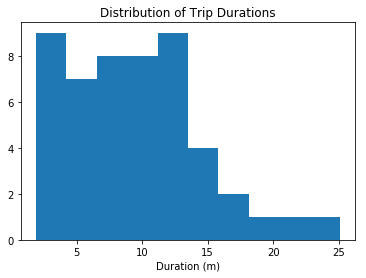

In [26]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. 
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and generated a histogram to show their distribution.

Below, I created a histogram of the trip times for New York City. 

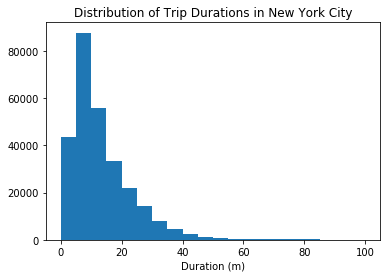

In [27]:
# collect all of the trip times as a list 
times=[]
with open('./data/NYC-2016-Summary.csv', 'r') as f_in:
    # set up csv reader object
    reader = csv.DictReader(f_in)
    for row in reader:
        times.append(float(row['duration']))
        
#using pyplot functions to generate a histogram of trip times.   
plt.hist(times, range=[0,100], bins=20)
plt.title('Distribution of Trip Durations in New York City')
plt.xlabel('Duration (m)')
plt.show()

**Question 5**: 
1. Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in New York City. 
2. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. 
3. For each group, where is the peak of each distribution? 
4. How would you describe the shape of each distribution?

**Answer**: 
1. The plot is shown below
2. The plot is shown below
3. The peak of subscribers is within the range of 5 and 10, while that of customers is between the range of 20 and 25. 
4. Both distributions are skewed to the right, that is, the mean is greater than the median, which is greater than the mode.
From the distribution, it is observed that most subscribers rice for 5-15mins on average, while customers ride for 15-30mins on average.

Text(0.5,0,'Duration (m)')

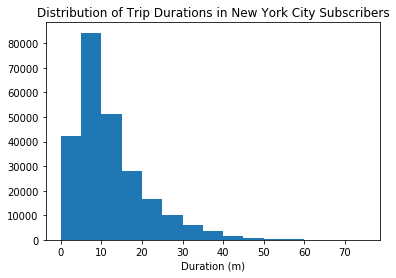

In [28]:
## to answer Question 5a

# collect all of the trip times of customers as a list 
cus_times=[]
# collect all of the trip times of subscribers as a list 
sub_times=[]

with open('./data/NYC-2016-Summary.csv', 'r') as f_in:
    # set up csv reader object
    reader = csv.DictReader(f_in)
    for row in reader:
        if row['user_type'] == 'Subscriber':
            sub_times.append(float(row['duration']))
        else:
            cus_times.append(float(row['duration']))

#using pyplot functions to generate a histogram of subscribers' trip times
plt.hist(sub_times,range=[0,75], bins=15)
plt.title('Distribution of Trip Durations in New York City Subscribers')
plt.xlabel('Duration (m)')


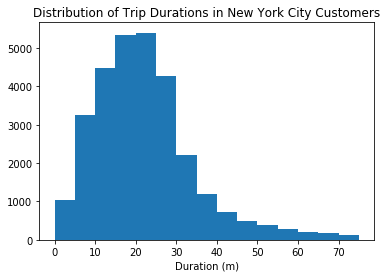

In [29]:
## to answer Question 5b

#using pyplot functions to generate a histogram of trip times
plt.hist(cus_times, range=[0,75],bins=15)
plt.title('Distribution of Trip Durations in New York City Customers')
plt.xlabel('Duration (m)')
plt.show()


<a id='eda_continued'></a>
## Performing My Own Analysis

So far, I've performed an initial exploration into the data available. I compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, I investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. I continued the exploration in a direction that I choose. 

**Question 6**: 
1. Which month has the highest ridership in New York City?
2. Which day of the week has the highest ridership count in New York City?
3. Is the pattern of ridership different on the weekends versus weekdays in NYC?

**Answer**: 
1. From the bar chart below, september appears to have the highest ridership in New York City. It is closely followed by June.
2. From the chart below, wednesday has the highest ridership count, followed closely by Thursday
3. Even though weekdays appear to have higher ridership that weekends, the pattern of ridership are not so different.

In [31]:
#to answer 6a.

# initialize count variables
jan=0
feb=0
mar=0
apr=0
may=0
jun=0
jul=0
aug=0
sep=0
oct=0
nov=0
dec=0

with open('./data/NYC-2016-Summary.csv', 'r') as f_in:
    # set up csv reader object
    reader = csv.DictReader(f_in)
    
    #get the total ridership for each month
    for row in reader:
        if row['month'] == '1':            
            jan+=float(row['duration'])
        elif row['month'] == '2':            
            feb+=float(row['duration'])
        elif row['month'] == '3':    
            mar+=float(row['duration'])
        elif row['month'] == '4':            
            apr+=float(row['duration'])
        elif row['month'] == '5':            
            may+=float(row['duration'])
        elif row['month'] == '6':            
            jun+=float(row['duration'])
        elif row['month'] == '7':            
            jul+=float(row['duration'])
        elif row['month'] == '8':            
            aug+=float(row['duration'])
        elif row['month'] == '9':            
            sep+=float(row['duration'])
        elif row['month'] == '10':            
            oct+=float(row['duration'])
        elif row['month'] == '11':            
            nov+=float(row['duration'])
        else:            
            dec+=float(row['duration'])
                
            

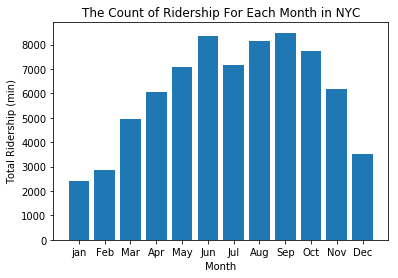

In [39]:
#convert the total times for each month from seconds to minutes
dat=[jan/60,feb/60,mar/60,apr/60,may/60,jun/60,jul/60,aug/60,sep/60,oct/60,nov/60,dec/60]

#to plot the graph for each month's ridership
x = np.arange(12)
plt.bar(x, dat)
plt.xticks(x, ('jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.xlabel("Month")
plt.ylabel("Total Ridership (min)")
plt.title("The Count of Ridership For Each Month in NYC")
plt.show()

In [40]:
#to answer Question 6b

# initialize count variables
mon=0
mon_duration=0
tue=0
tue_duration=0
wed=0
wed_duration=0
thur=0
thur_duration=0
fri=0
fri_duration=0
sat=0
sat_duration=0
sun=0
sun_duration=0

with open('./data/NYC-2016-Summary.csv', 'r') as f_in:
    # set up csv reader object
    reader = csv.DictReader(f_in)
    
    for row in reader:
        if row['day_of_week'] == 'Sunday':
            sun+=1 #get the count of rides for sundays
            sun_duration+=float(row['duration'])   #get the total ridership for sundays     
        elif row['day_of_week'] == 'Saturday':
            sat+=1 
            sat_duration+=float(row['duration'])        
        elif row['day_of_week'] == 'Friday':
            fri+=1 
            fri_duration+=float(row['duration'])
        elif row['day_of_week'] == 'Thursday':
            thur+=1   
            thur_duration+=float(row['duration'])
        elif row['day_of_week'] == 'Wednesday':
            wed+=1  
            wed_duration+=float(row['duration'])
        elif row['day_of_week'] == 'Tuesday':
            tue+=1    
            tue_duration+=float(row['duration'])
        else:
            mon+=1          
            mon_duration+=float(row['duration'])
            

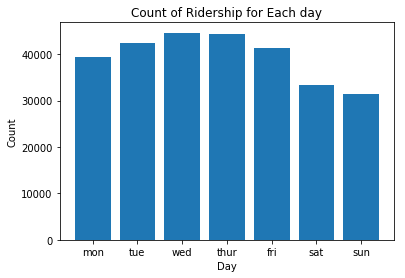

In [45]:
#collect the count of daily ridership
dat=[mon,tue,wed,thur,fri,sat,sun]

#to plot the chart for the total ridership count for each day
x = np.arange(7)
plt.bar(x, dat)
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(x, ('mon','tue','wed','thur','fri','sat','sun'))
plt.title("Count of Ridership for Each day")
plt.show()

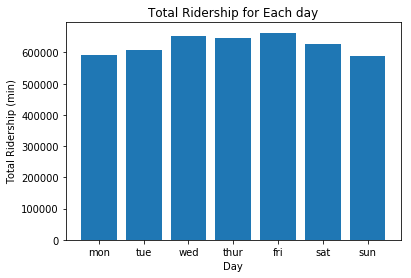

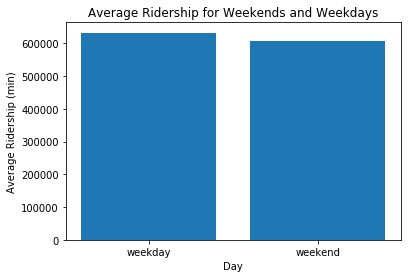

In [53]:
#collect the total daily ridership
dat=[mon_duration,tue_duration,wed_duration,thur_duration,fri_duration,sat_duration,sun_duration]
weekday=sum(dat[:5])/5
weekend=sum(dat[5:])/2

#to plot the chart for the total ridership count for each day
x = np.arange(7)
plt.bar(x, dat)
plt.xlabel("Day")
plt.ylabel("Total Ridership (min)")
plt.xticks(x, ('mon','tue','wed','thur','fri','sat','sun'))
plt.title("Total Ridership for Each day")
plt.show()

#to plot the chart for the average ridership for Weekends and Weekdays
x = np.arange(2)
plt.bar(x, [weekday, weekend])
plt.xlabel("Day")
plt.ylabel("Average Ridership (min)")
plt.xticks(x, ('weekday','weekend'))
plt.title("Average Ridership for Weekends and Weekdays")
plt.show()

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: 
1. I will like to apply it on issues relating to elections results; finding out the factors that affect the results, and what kind of candidate people vote for. 
2. I will also like to use this skill in analyzing the causes of traffic in Lagos State, Nigeria; and how to mitigate it.


In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0